# Emotion Recognition FER2013

   ![](https://www.researchgate.net/profile/Garima-Verma-3/publication/343556711/figure/fig1/AS:933334486114318@1599535690875/Sample-of-the-FER2013-dataset.png)

## Imports

In [166]:

import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D,concatenate
from keras.models import Model
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

## Parameters

In [53]:

batch_size = 32
num_epochs = 50
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)

## Data 

In [54]:
data=pd.read_csv('../input/fer2013/fer2013.csv')

## Preprocessing

In [55]:
data['pixels']=data['pixels'].astype("string")
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'),image_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 127.5
faces -= 1.
emotions = pd.get_dummies(data['emotion']).to_numpy()

## Data Augmentation

In [58]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [126]:
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.3,shuffle=True)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,test_size=0.3,shuffle=True)

## Xception :
[PAPER](https://arxiv.org/pdf/1610.02357.pdf)

![](https://www.researchgate.net/publication/342580102/figure/fig3/AS:908305815830530@1593568390179/Schematic-diagram-of-the-Xception-model.png)

In [60]:
def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [64, 128, 256] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [61]:
def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

In [62]:
def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

In [63]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [64]:
xception = Model(inputs, outputs,name="Xception")

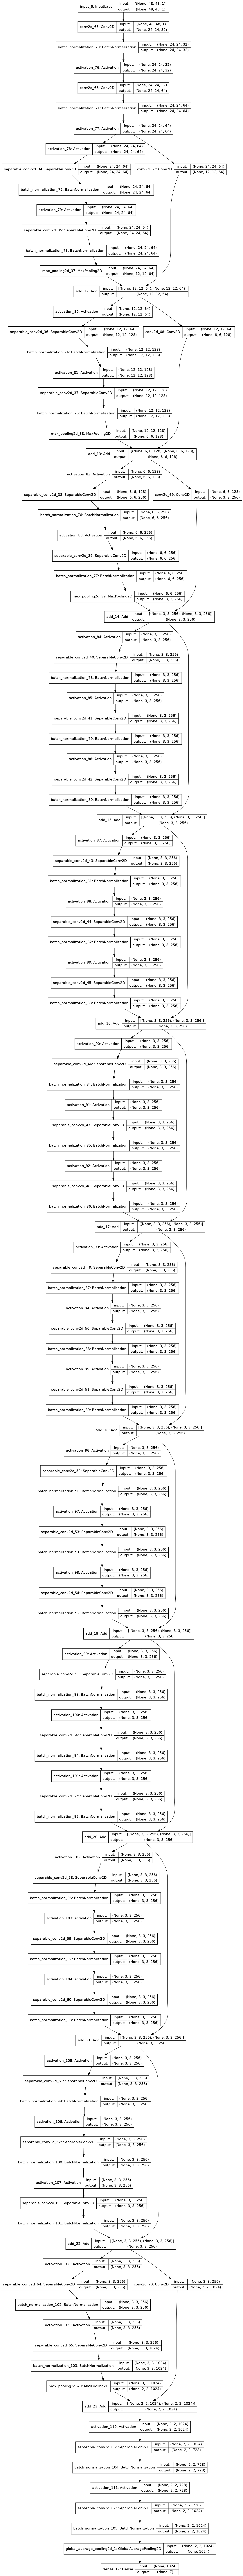

In [65]:
plot_model(xception, to_file='xception.png', show_shapes=True, show_layer_names=True)

In [66]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xception.summary()

Model: "Xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 24, 24, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 24, 24, 32)   128         conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 24, 24, 32)   0           batch_normalization_70[0][0]     
___________________________________________________________________________________________

## Dexpression
[PAPER](https://arxiv.org/pdf/1509.05371.pdf)

![](https://qph.fs.quoracdn.net/main-qimg-252e5047af30f8ea18def43bb35dbf41.webp)

In [71]:
def dexpression():
    inputs = Input(shape=(shape_x, shape_y, 1))

    x = Conv2D(64, 7, strides = 2, padding='same')(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    x_1 = Conv2D(96, 1, strides = 1, padding='same')(x)
    x_1 = Activation('relu')(x_1)
    x_1 = MaxPooling2D(3, strides=1, padding='same')(x_1)
    x_1 = BatchNormalization()(x_1)

    x_2 = Conv2D(208, 3, strides = 1, padding='same')(x_1)
    x_2 = Activation('relu')(x_2)
    x_2 = MaxPooling2D(3, strides=1, padding='same')(x_2)

    x_3 = Conv2D(64, 1, strides = 1, padding='same')(x_1)
    x_3 = Activation('relu')(x_3)
    x_3 = MaxPooling2D(3, strides=1, padding='same')(x_3)


    x_4=concatenate([x_2,x_3],axis=3)

    x_5 = Conv2D(96, 1, strides = 1, padding='same')(x_4)
    x_5 = Activation('relu')(x_5)
    x_5 = Conv2D(208, 3, strides = 1, padding='same')(x_5)
    x_5 = Activation('relu')(x_5)

    x_6 = MaxPooling2D(3, strides=1, padding='same')(x_4)
    x_6 = Activation('relu')(x_6)
    x_6 = Conv2D(64, 1, strides = 1, padding='same')(x_6)
    x_6 = Activation('relu')(x_6)
    x_6 = MaxPooling2D(3, strides=1, padding='same')(x_6)
    x_7 = concatenate([x_5,x_6],axis=3)

    x_8 = Flatten()(x_7)
    x_8 = Dropout(0.25)(x_8)
    x_8 = Dense(7, activation='softmax')(x_8)
    return Model(inputs, x_8,name='DeXpression')

In [72]:
dexpression=dexpression()

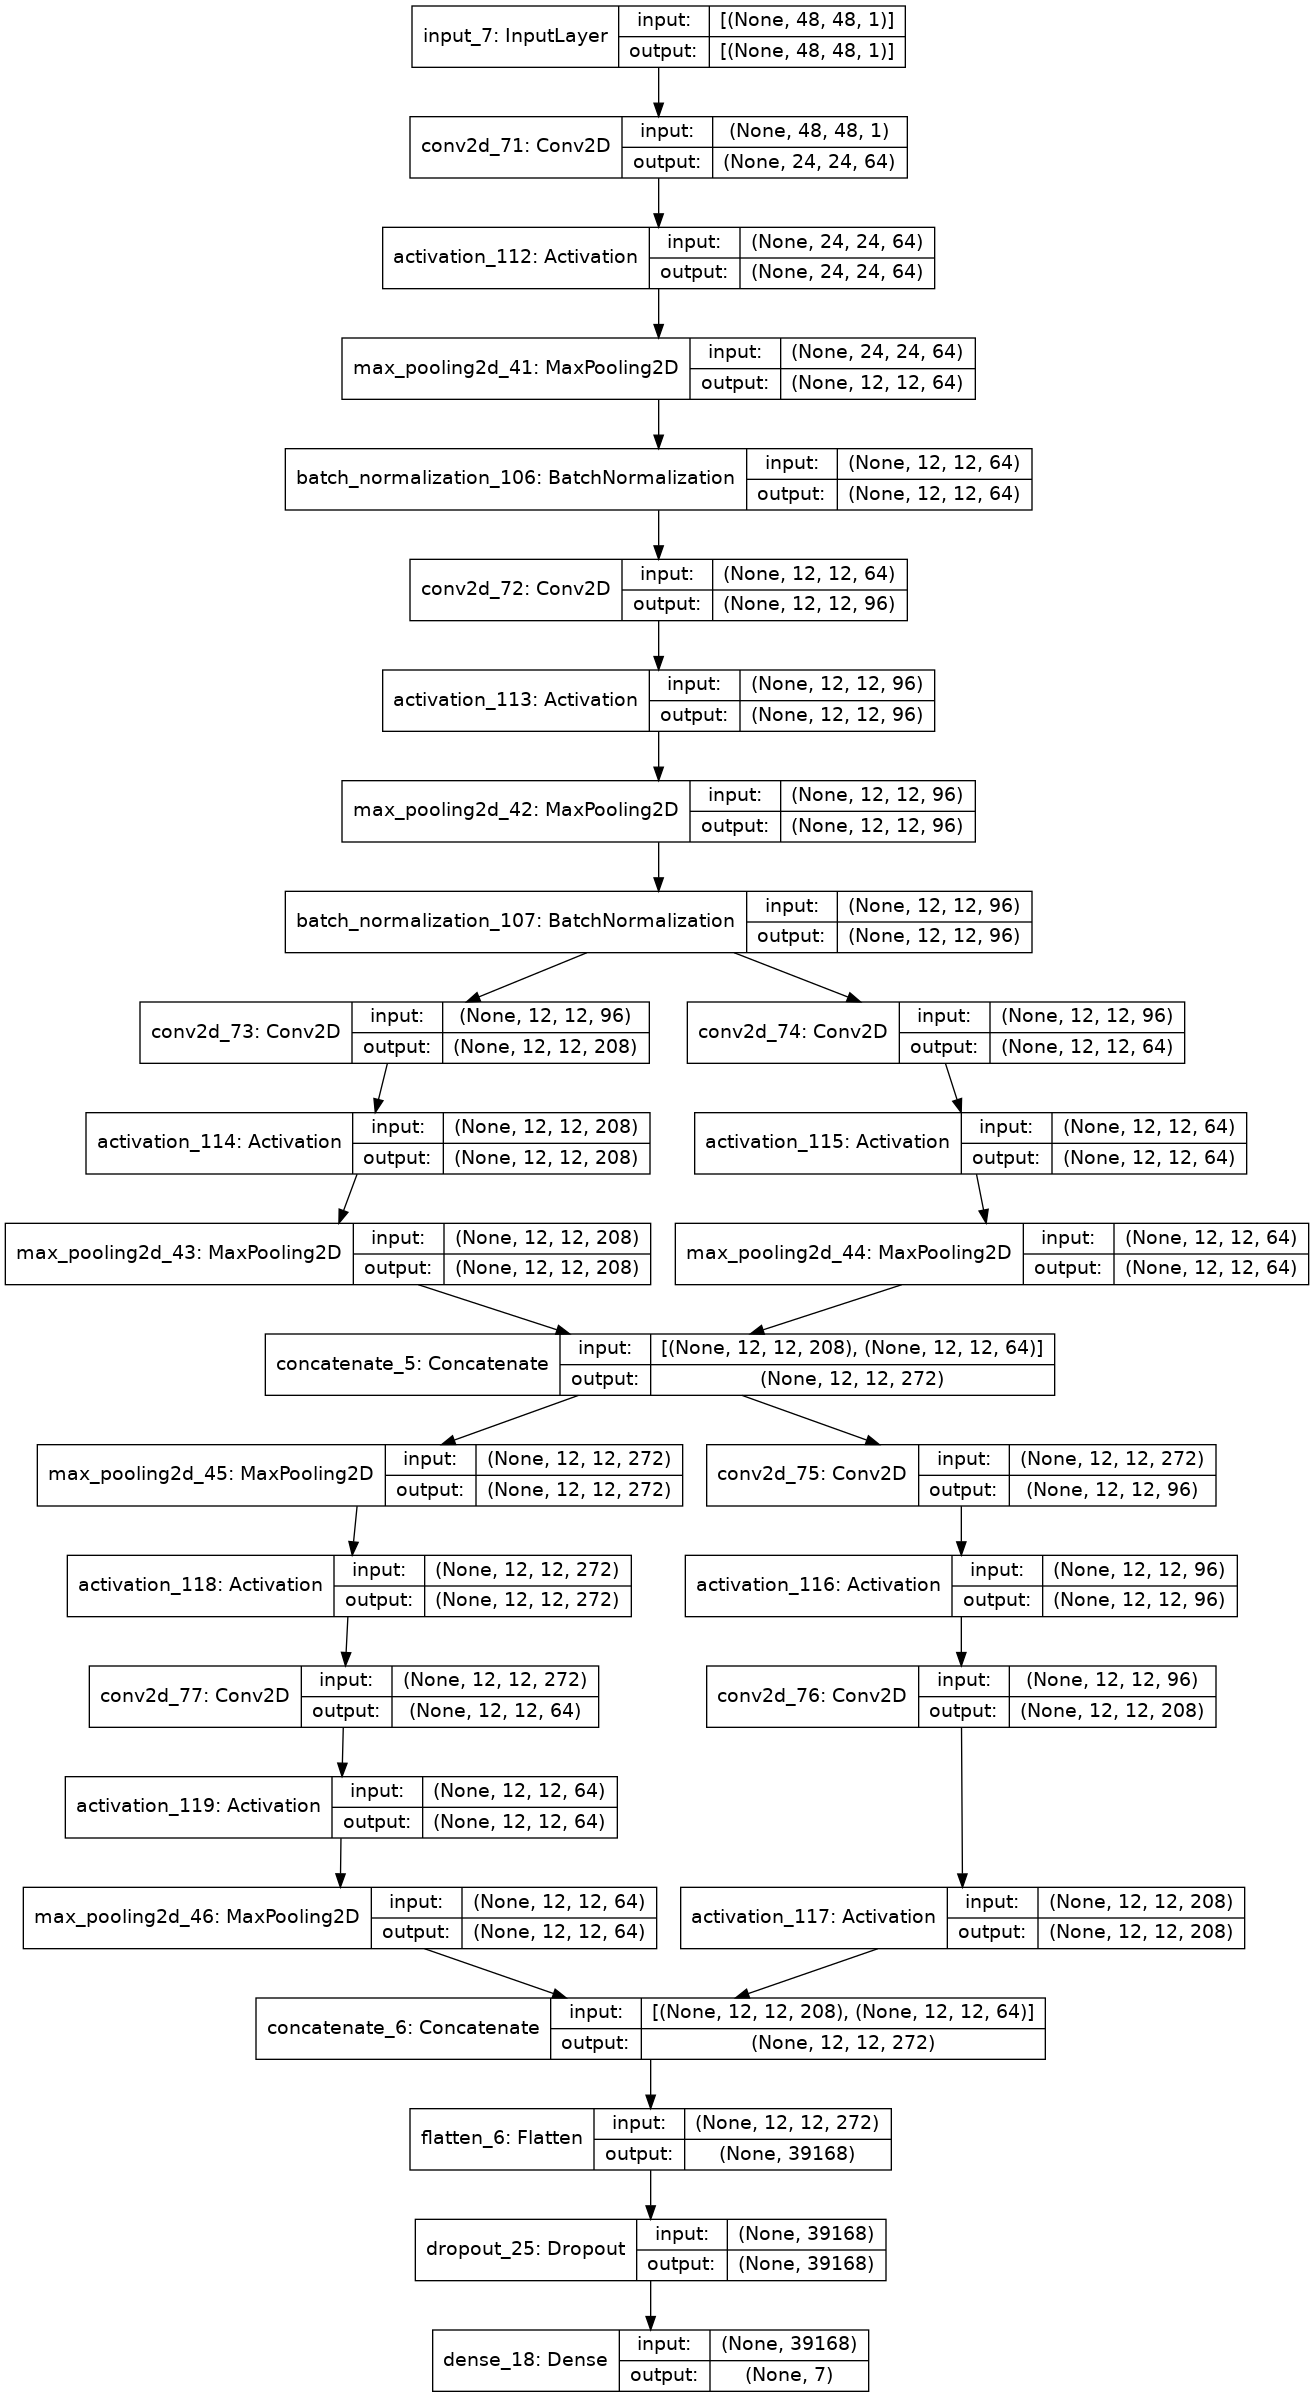

In [73]:
plot_model(dexpression, to_file='dexpression.png', show_shapes=True, show_layer_names=True)

In [74]:
dexpression.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dexpression.summary()

Model: "DeXpression"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 24, 24, 64)   3200        input_7[0][0]                    
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 24, 24, 64)   0           conv2d_71[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 12, 12, 64)   0           activation_112[0][0]             
________________________________________________________________________________________

## CNN inspired by Goodfellow I.J
[PAPER](https://arxiv.org/pdf/1307.0414.pdf)

![](https://raw.githubusercontent.com/NJNischal/Facial-Expression-Recognition-with-CNNs/9999cbdaa55542e86e11a9e129bafcfb96bd0e60/model.png)

In [75]:
def CNN():
    model = Sequential(name='CNN')
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    return model

In [76]:
CNN=CNN()

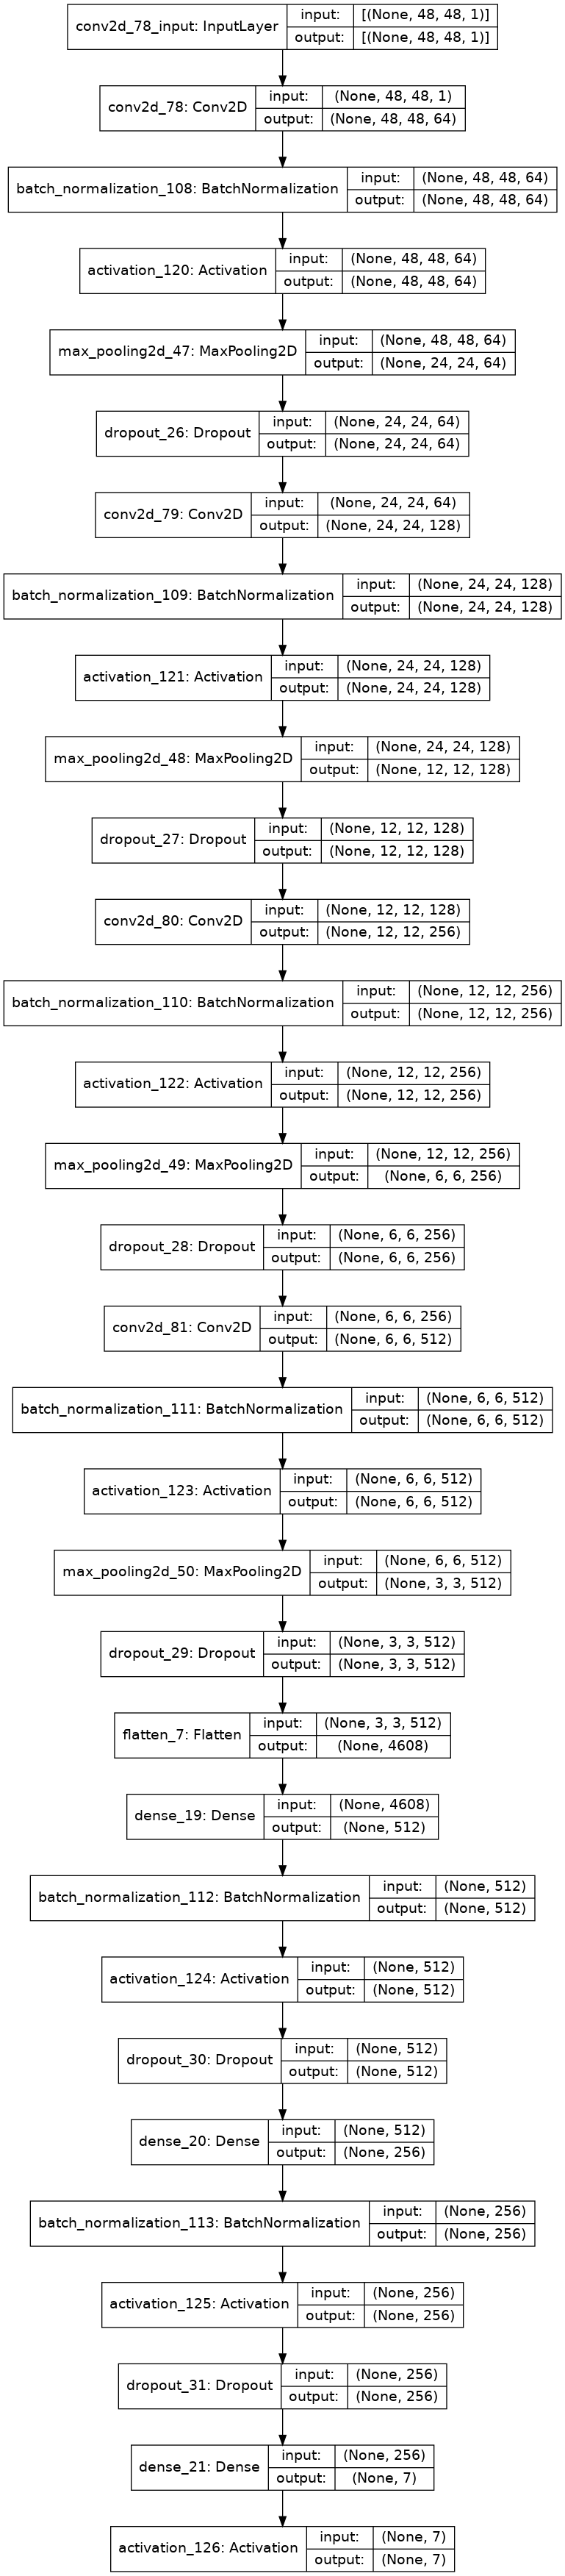

In [77]:
plot_model(CNN, to_file='CNN.png', show_shapes=True, show_layer_names=True)

In [78]:
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
CNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_108 (Bat (None, 48, 48, 64)        256       
_________________________________________________________________
activation_120 (Activation)  (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_109 (Bat (None, 24, 24, 128)       512     

# Training 
## Xception

In [81]:

early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=50, min_lr=0.00001,model='auto')
trained_models_path = base_path + '_Xception'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [82]:
xception_history =xception.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/50
785/785 [==============================] - 31s 34ms/step - loss: 1.7481 - accuracy: 0.2957 - val_loss: 2.1442 - val_accuracy: 0.3450

Epoch 00001: val_loss improved from inf to 2.14424, saving model to models/_Xception.01-0.35.hdf5
Epoch 2/50
785/785 [==============================] - 26s 33ms/step - loss: 1.5104 - accuracy: 0.4090 - val_loss: 1.6454 - val_accuracy: 0.4285

Epoch 00002: val_loss improved from 2.14424 to 1.64543, saving model to models/_Xception.02-0.43.hdf5
Epoch 3/50
785/785 [==============================] - 26s 33ms/step - loss: 1.3893 - accuracy: 0.4668 - val_loss: 2.8171 - val_accuracy: 0.1570

Epoch 00003: val_loss did not improve from 1.64543
Epoch 4/50
785/785 [==============================] - 26s 32ms/step - loss: 1.3222 - accuracy: 0.4957 - val_loss: 1.9392 - val_accuracy: 0.3110

Epoch 00004: val_loss did not improve from 1.64543
Epoch 5/50
785/785 [==============================] - 25s 32ms/step - loss: 1.2718 - accuracy: 0.5168 - val_loss: 1.41

## Dexpression

In [83]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + '_DeXpression'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [84]:
dexpression_history =dexpression.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/50
785/785 [==============================] - 20s 25ms/step - loss: 1.9828 - accuracy: 0.2456 - val_loss: 1.7005 - val_accuracy: 0.3166

Epoch 00001: val_loss improved from inf to 1.70047, saving model to models/_DeXpression.01-0.32.hdf5
Epoch 2/50
785/785 [==============================] - 19s 24ms/step - loss: 1.6795 - accuracy: 0.3253 - val_loss: 1.5553 - val_accuracy: 0.3888

Epoch 00002: val_loss improved from 1.70047 to 1.55530, saving model to models/_DeXpression.02-0.39.hdf5
Epoch 3/50
785/785 [==============================] - 20s 25ms/step - loss: 1.5844 - accuracy: 0.3803 - val_loss: 1.5402 - val_accuracy: 0.3989

Epoch 00003: val_loss improved from 1.55530 to 1.54018, saving model to models/_DeXpression.03-0.40.hdf5
Epoch 4/50
785/785 [==============================] - 19s 25ms/step - loss: 1.5260 - accuracy: 0.4043 - val_loss: 1.4750 - val_accuracy: 0.4368

Epoch 00004: val_loss improved from 1.54018 to 1.47497, saving model to models/_DeXpression.04-0.44.hdf5
Epoc

## CNN


In [79]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + 'CNN'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [80]:
CNN_history =CNN.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/50
785/785 [==============================] - 15s 18ms/step - loss: 1.9380 - accuracy: 0.2491 - val_loss: 1.5393 - val_accuracy: 0.3984

Epoch 00001: val_loss improved from inf to 1.53929, saving model to models/CNN.01-0.40.hdf5
Epoch 2/50
785/785 [==============================] - 14s 18ms/step - loss: 1.5871 - accuracy: 0.3780 - val_loss: 1.3526 - val_accuracy: 0.4659

Epoch 00002: val_loss improved from 1.53929 to 1.35257, saving model to models/CNN.02-0.47.hdf5
Epoch 3/50
785/785 [==============================] - 14s 17ms/step - loss: 1.4425 - accuracy: 0.4418 - val_loss: 1.2966 - val_accuracy: 0.5049

Epoch 00003: val_loss improved from 1.35257 to 1.29656, saving model to models/CNN.03-0.50.hdf5
Epoch 4/50
785/785 [==============================] - 14s 17ms/step - loss: 1.3622 - accuracy: 0.4790 - val_loss: 1.2228 - val_accuracy: 0.5265

Epoch 00004: val_loss improved from 1.29656 to 1.22282, saving model to models/CNN.04-0.53.hdf5
Epoch 5/50
785/785 [====================

## Testing

### Plotting accuracy and loss curves 

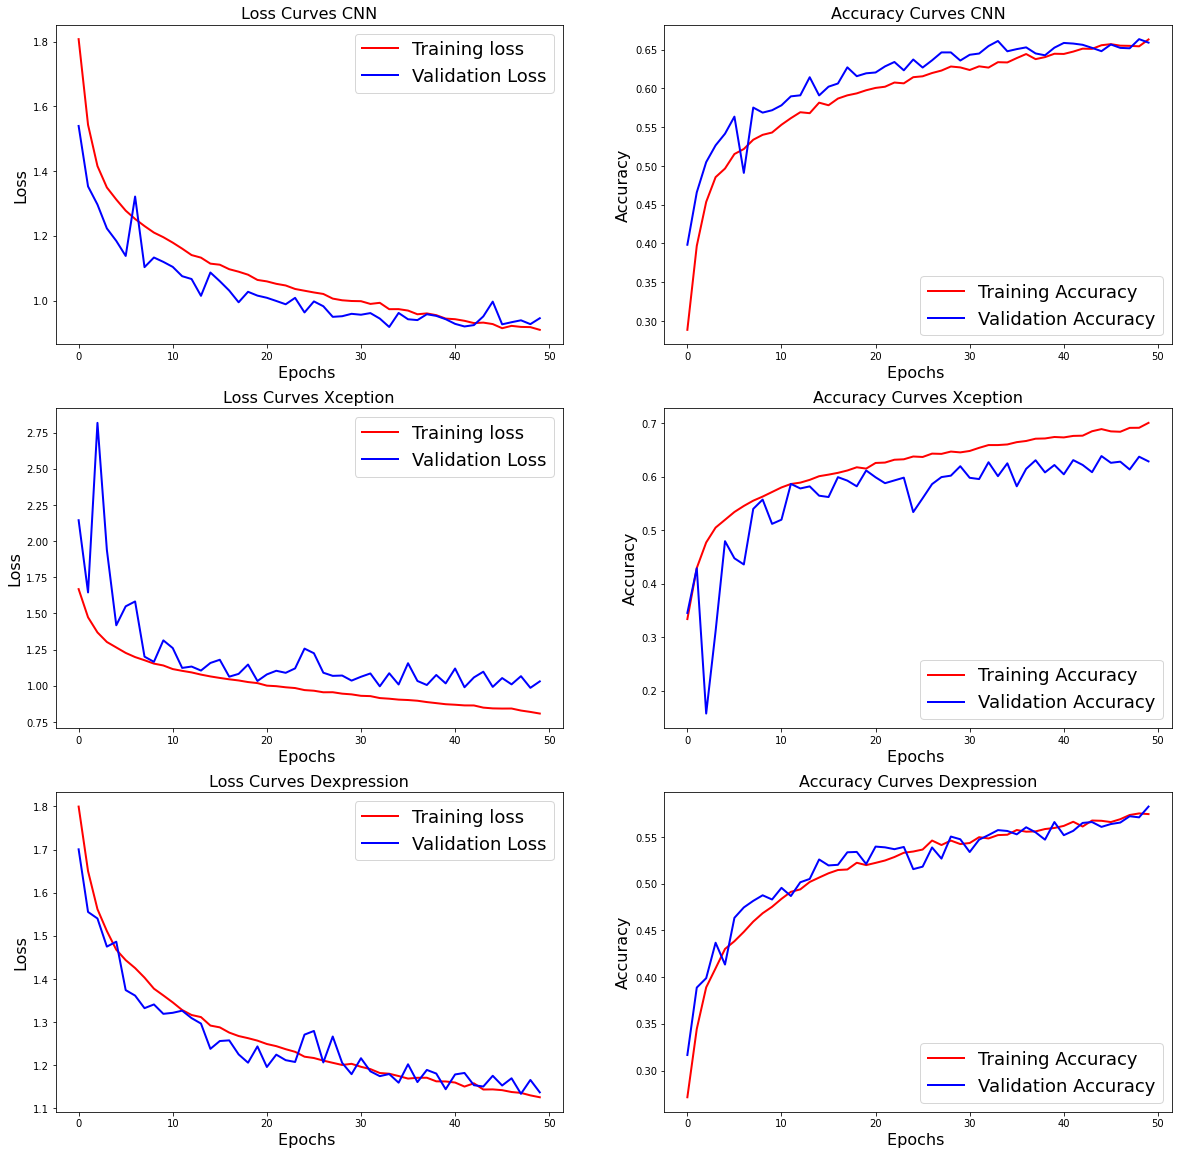

In [102]:

fig,axes=plt.subplots(3,2,figsize=(20, 20))
for (m,history), ax in zip({'CNN':CNN_history,'Xception':xception_history,'Dexpression':dexpression_history}.items(),axes):
    # Loss Curves
    
    ax[0].plot(history.history['loss'],'r',linewidth=2.0)
    ax[0].plot(history.history['val_loss'],'b',linewidth=2.0)
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Loss Curves '+m,fontsize=16)
 
    # Accuracy Curves
    ax[1].plot(history.history['accuracy'],'r',linewidth=2.0)
    ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Accuracy Curves '+m,fontsize=16)

In [103]:
plt.savefig('plots.png')

<Figure size 432x288 with 0 Axes>

### Classification reports

In [135]:

for model in [CNN,xception,dexpression]:
    ypred=model.predict(xtest)
    ypred_=np.argmax(ypred, axis=1)
    ytest_=np.argmax(ytest, axis=1)
    print(classification_report(ytest_, ypred_,digits=3))
    


[5 6 3 ... 0 5 3]
              precision    recall  f1-score   support

           0      0.628     0.684     0.655       412
           1      0.818     0.581     0.679        62
           2      0.749     0.333     0.461       457
           3      0.899     0.888     0.894       846
           4      0.638     0.571     0.603       539
           5      0.767     0.848     0.806       330
           6      0.595     0.867     0.706       585

    accuracy                          0.717      3231
   macro avg      0.728     0.682     0.686      3231
weighted avg      0.730     0.717     0.706      3231

[5 6 3 ... 0 5 3]
              precision    recall  f1-score   support

           0      0.675     0.585     0.627       412
           1      0.902     0.597     0.718        62
           2      0.644     0.420     0.509       457
           3      0.886     0.914     0.900       846
           4      0.484     0.675     0.564       539
           5      0.837     0.776     0.80

### Confusion Matrix

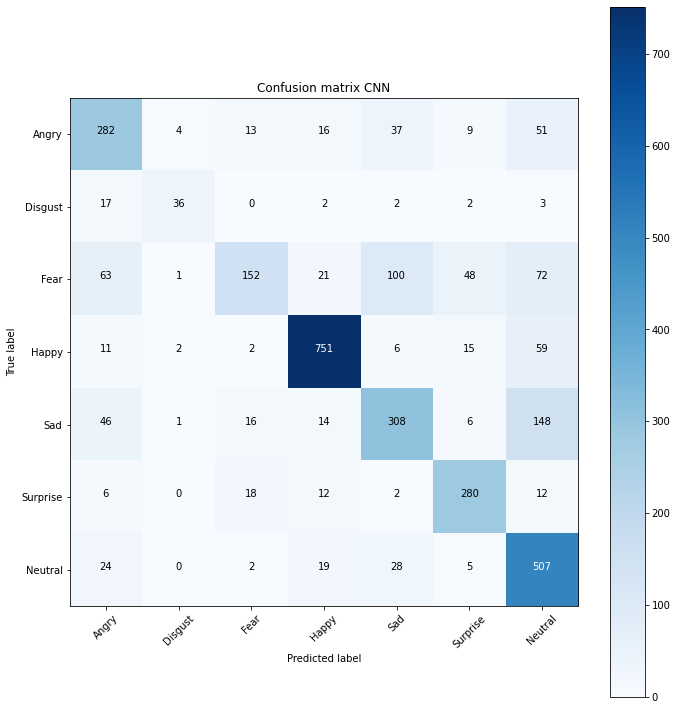

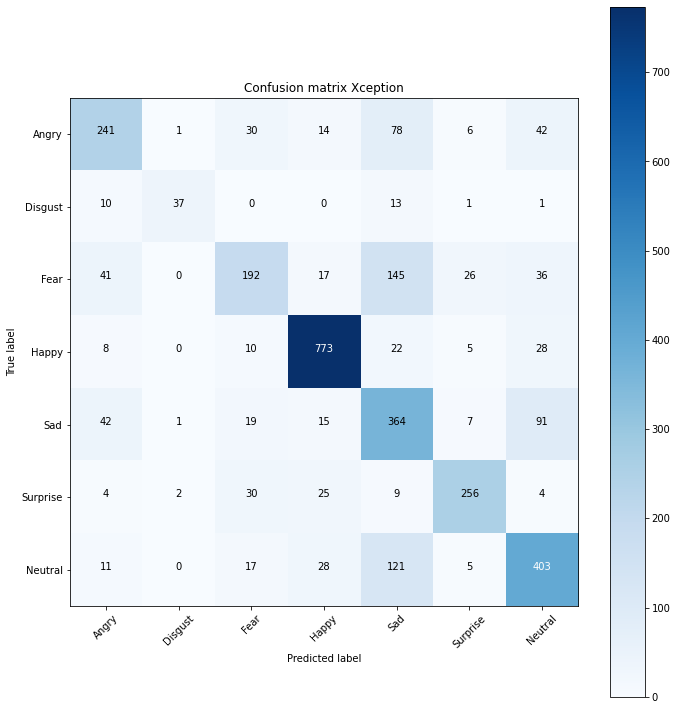

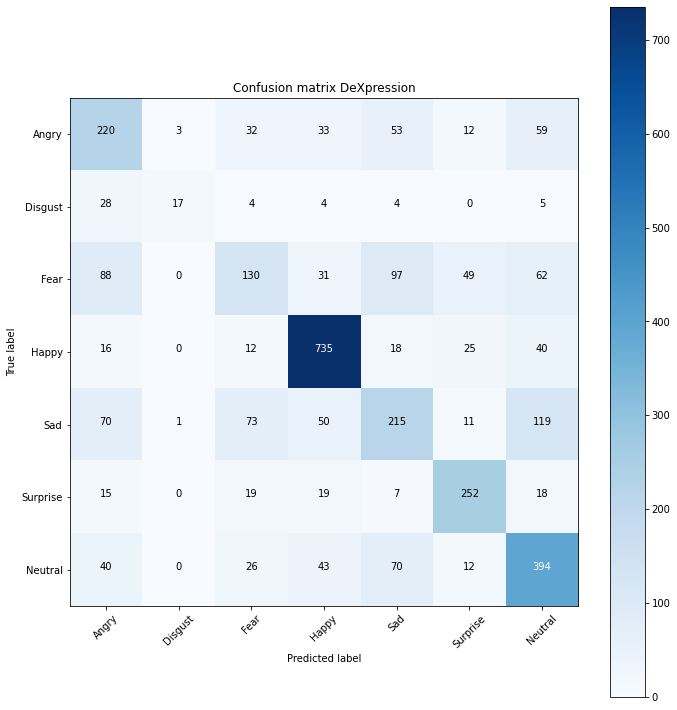

In [168]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure


for model,i in zip([CNN,xception,dexpression],[1,2,3]):
    fig = figure(figsize=(10, 10))
    
    ypred=model.predict(xtest)
    rounded_predections=np.argmax(ypred, axis=1)
    rounded_labels=np.argmax(ytest, axis=1)
    cm = confusion_matrix(rounded_labels, rounded_predections)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    title='Confusion matrix '+model.name
    

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_'+model.name+'.png')
    plt.show()
    